# This is just running detect on validation images that a model was trained on

In [15]:
import numpy as np
import pandas as pd
import os

import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
import plotly.io as pio
from plotly.subplots import make_subplots
# setting default template to plotly_white for all visualizations
pio.templates.default = "plotly_white"
%matplotlib inline
import gc

import utils_eda as uteda

import warnings
warnings.filterwarnings('ignore')
#get a list of all the files
from tqdm.auto import tqdm

%load_ext autoreload
%autoreload 2

Running seed_everything... DONE!


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
IMAGES_PATH = '/home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/tmp/covid/images/valid'
PROJECT='PROJECT_med_large_models_siim_covid_detect'
USE_SMALL_SET=False
SHOW_IMAGES=''

In [17]:
USE_SMALL_SET=False #use this to display images that detect generates

In [18]:
if USE_SMALL_SET is True:
    #make a really small valid set so 
    fls = uteda.get_files(IMAGES_PATH)
    fls=fls[:10]   

    #create dir name
    IMAGES_PATH = IMAGES_PATH.split('/')[:-1]
    IMAGES_PATH.append('valid_small')
    IMAGES_PATH= '/'.join(map(str,IMAGES_PATH))
    
    os.makedirs(IMAGES_PATH, exist_ok=True)
    
    for fle in fls:
        import shutil
        shutil.copy2(fle, IMAGES_PATH) # target filename is /dst/dir/file.ext
#     SHOW_IMAGES=' --view-img '


In [19]:
#how many files are we working on?
!ls -la {IMAGES_PATH} |wc -l

637


# Load a trained yolov5 models and run predictions on files in IMAGES_PATH.


# Run models, or ensembles of models


In [20]:
# keys= name of the predict output dir
# vals=model weights we are using per run 
import os

cwd = os.path.abspath(os.getcwd())

#config1
#CV folds, yolo5s on 512 images
weights0=cwd +"/PROJECT_kaggle-siim-covid-CV/fold_0.pt"
weights1=cwd +"/PROJECT_kaggle-siim-covid-CV/fold_1.pt"
weights2=cwd +"/PROJECT_kaggle-siim-covid-CV/fold_2.pt"
weights3=cwd +"/PROJECT_kaggle-siim-covid-CV/fold_3.pt"
weights4=cwd +"/PROJECT_kaggle-siim-covid-CV/fold_4.pt"
weights50=cwd +f"/{PROJECT}/yolov5m.pt"

run_names=['fld0','fld1','fld2','fld3','fld4','fld5']
#weights, confidence, F1 score
model_weights=[ [weights0,"0.001",0.5], [weights1, ".001",0.5],[weights2,".001",0.5], [weights3,".001",0.75], [weights4,".001",0.85], [weights50,".001",0.95]]

#config 2
#random large and medium models
# weights00=cwd +f"/{PROJECT}/exp10_yolov5l_img512_1class.pt"
# weights10=cwd +f"/{PROJECT}/exp11_yolov5l_img512_1class.pt"
# weights20=cwd +f"/{PROJECT}/exp12_yolov5m_img512_1class.pt"
# weights30=cwd +f"/{PROJECT}/yolov5m.pt"
# weights40=cwd +f"/{PROJECT}/best_from_kaggle_sub_1class.pt"
# # run_names=['fld0','fld1','fld2', 'fld3']
# run_names=['fld0']
# run_weights=[1]

#weights, confidence, F1 score
# model_weights=[[weights30,".001",0.52]]
# model_weights=[[weights30,".001",0.52], [weights40,".001",0.52]]

#config3
# weights000=cwd +f"/{PROJECT}/best.pt"
# run_names=['fld0']
# #weights, confidence, F1 score
# model_weights=[ [weights000,"0.001",0.52]]

model_sel=dict(zip(run_names,model_weights))
model_sel

#set up wbf
# generte run info
run_info={key:val[2]for key, val in model_sel.items()}
# run_info={key:1for key, val in model_sel.items()}
# run_info={'fld0':1,'fld1':1,'fld2':1,'fld3':1,'fld4':1,'fld5':1.25}
# run_info={'fld0': 2, 'fld1': 2, 'fld2': 1}
# run_info={'fld0':  1}

# run_info={'fld3': 1}#TODO test
print(run_info)
print(model_sel)

{'fld0': 0.5, 'fld1': 0.5, 'fld2': 0.5, 'fld3': 0.75, 'fld4': 0.85, 'fld5': 0.95}
{'fld0': ['/home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/PROJECT_kaggle-siim-covid-CV/fold_0.pt', '0.001', 0.5], 'fld1': ['/home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/PROJECT_kaggle-siim-covid-CV/fold_1.pt', '.001', 0.5], 'fld2': ['/home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/PROJECT_kaggle-siim-covid-CV/fold_2.pt', '.001', 0.5], 'fld3': ['/home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/PROJECT_kaggle-siim-covid-CV/fold_3.pt', '.001', 0.75], 'fld4': ['/home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/PROJECT_kaggle-siim-covid-CV/fold_4.pt', '.001', 0.85], 'fld5': ['/home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/PROJECT_med_large_models_siim_covid_detect/yolov5m.pt', '.001', 0.95]}


In [22]:
%%time
%cd tmp/yolov5

for key, val in model_sel.items(): 
    print(key)
    %rm -rf ./runs/detect/{key}

    params="--weights " + val[0]+" --source " + IMAGES_PATH+ "  --img 512 --conf " + val[1] +" --iou-thres 0.5 --max-det 50  --save-txt  --save-conf --name " + key + " --exist-ok" + SHOW_IMAGES
    print('***' +params)
    !python detect.py {params} >out.txt
    
# #get back to correct dir
%cd ../..

/home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/tmp/yolov5
fld0
***--weights /home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/PROJECT_kaggle-siim-covid-CV/fold_0.pt --source /home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/tmp/covid/images/valid  --img 512 --conf 0.001 --iou-thres 0.5 --max-det 50  --save-txt  --save-conf --name fld0 --exist-ok
YOLOv5 🚀 v5.0-294-gdd62e2d torch 1.9.0+cu102 CUDA:0 (TITAN Xp, 12194.0625MB)

Fusing layers... 
/home/keith/anaconda3/envs/p39/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPs
fld1
***--weights /home/keith/AA_jupyte

# Outputs are in ./tmp/yolov5/runs/detect/exp15 (exp16 etc)
## labels are in ./tmp/yolov5/runs/detect/exp15/labels 
## 1st is class, last is confidence.  Looks like following
1 0.326869 0.343108 0.252468 0.463613 0.402857 <br>
1 0.695874 0.373716 0.246474 0.478596 0.450281


# Select from image_df all rows where id is in fls1

In [23]:
#how many files did detect run on?
fles=uteda.get_files(IMAGES_PATH)
print(f'number files detected {len(fles)}')

#lets get the image id
fls1=[fle.split('/')[-1] for fle in fles]
fls1=[fle.split('.')[0] for fle in fls1]
# fls1=['d3c5da1c1b1b'] #TODO test

image_df, study_df, submission=uteda.get_all_dataframes()
# image_df
df=image_df[image_df['id'].isin(fls1)]
df.reset_index(inplace=True, drop=True)

df.head()


number files detected 634


,id,boxes,label,StudyInstanceUID,dim0,dim1,split
0,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,3520,4280,train
1,004cbd797cd1,"[{'x': 515.18569, 'y': 1170.06439, 'width': 86...",opacity 1 515.18569 1170.06439 1378.5248700000...,30e45593ba08,2991,2992,train
2,01685340af75,"[{'x': 1800.21908, 'y': 745.90761, 'width': 67...",opacity 1 1800.21908 745.90761 2478.84115 1618...,0e9bece7e297,2330,2846,train
3,01b3d67779e8,NaN,none 1 0 0 1 1,b89d40fe2918,2801,2802,train
4,01bf68877dab,NaN,none 1 0 0 1 1,66b8524ee889,3480,4240,train


# Run WBF on results

In [8]:
print(run_info)

{'fld0': 0.5, 'fld1': 0.5, 'fld2': 0.5, 'fld3': 0.75, 'fld4': 0.85, 'fld5': 0.95}


In [14]:
%%time
pth = 'tmp/yolov5/runs/detect'
print(pth)
wbf=uteda.BBManager(pth, runs=run_info)

#see what different combos does
drop_below_this_conf_max=0.09

for val in np.linspace(0,.009,10):

print(wbf.runs)
wbf.do_all_imgs(drop_below_this_conf =0.05, run_nms=False, run_wbf=True, skip_box_thr=0.0001,out_put_dir='wbf_only')   
print("\n\n")
print(wbf.runs)
wbf.do_all_imgs(drop_below_this_conf =0.05, run_nms=True, run_wbf=False, skip_box_thr=0.0001,out_put_dir='nms_only' )
print("\n\n")
wbf.do_all_imgs(drop_below_this_conf =0.05, run_nms=True, run_wbf=True, skip_box_thr=0.0001,out_put_dir='nms_and_wbf' )


tmp/yolov5/runs/detect
{'fld0': 0.5, 'fld1': 0.5, 'fld2': 0.5, 'fld3': 0.75, 'fld4': 0.85, 'fld5': 0.95}
Image b284c7715348 has no boxes remaining above 0.0001!
('OH NO!wh->x1y1x2y2, values <0 or >1! [0.109375, 0.9531245, 0.275391, 1.0595700000000001]',)
('OH NO!wh->x1y1x2y2, values <0 or >1! [0.085938, 0.9023439, 0.308594, 1.0625]',)
Image 4145f29b1520 has no boxes remaining above 0.0001!
Image f5dd3b352196 has no boxes remaining above 0.0001!
('OH NO!wh->x1y1x2y2, values <0 or >1! [0.9160157999999999, 0.013672099999999993, 1.0000002, 0.1289063]',)
('OH NO!wh->x1y1x2y2, values <0 or >1! [-1.9999999999187335e-07, 0.001953399999999994, 0.1816408, 0.15917989999999999]',)
Image 24f00cdcedec has no boxes remaining above 0.0001!
('OH NO!wh->x1y1x2y2, values <0 or >1! [0.6738285, 0.7636719999999999, 0.9121095, 1.0009765]',)
Image 0a0bb7af0cab has no boxes remaining above 0.0001!
Image 01b3d67779e8 has no boxes remaining above 0.0001!
Image ed3682285d63 has no boxes remaining above 0.0001!
('

# Calculate mAP

#  display an image

In [11]:
OUTPUT_IMAGES_DIR='output_wbf_test_gt_bboxes/'
# RUNS=['fld0','fld1','fld2','fld3','fld4', 'wbf']
RUNS=['fld0','fld3','wbf']
# RUNS=['fld2']

RUNS=['nms_only','nms_and_wbf' ]
# RUNS=['wbf_only','nms_only','nms_and_wbf' ]

img_suffix='.png'
print(IMAGES_PATH)
print(OUTPUT_IMAGES_DIR)

/home/keith/AA_jupyter_tuts/kaggle_SIIM_COVID_Detection/tmp/covid/images/valid_small
output_wbf_test_gt_bboxes/


In [12]:
# uteda.generate_images(df, 2, IMAGES_PATH,OUTPUT_IMAGES_DIR, run_names=RUNS, show_image=True, img_suffix=img_suffix)

  0%|          | 0/25 [00:00<?, ?it/s]

Missing label file for image 01b3d67779e8.png for run nms_and_wbf


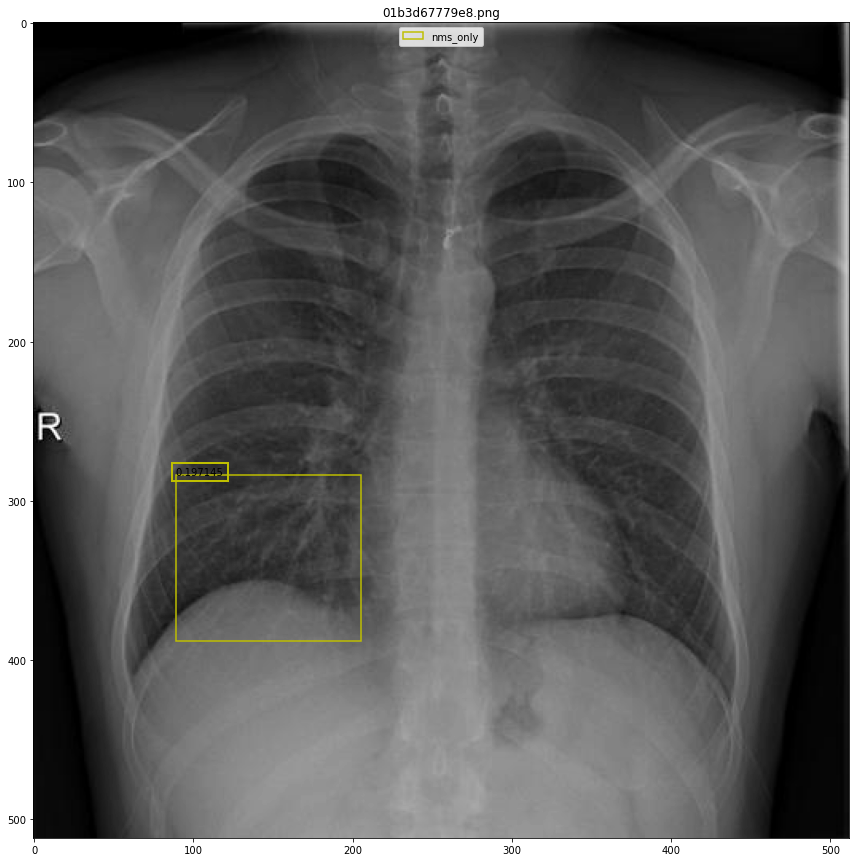

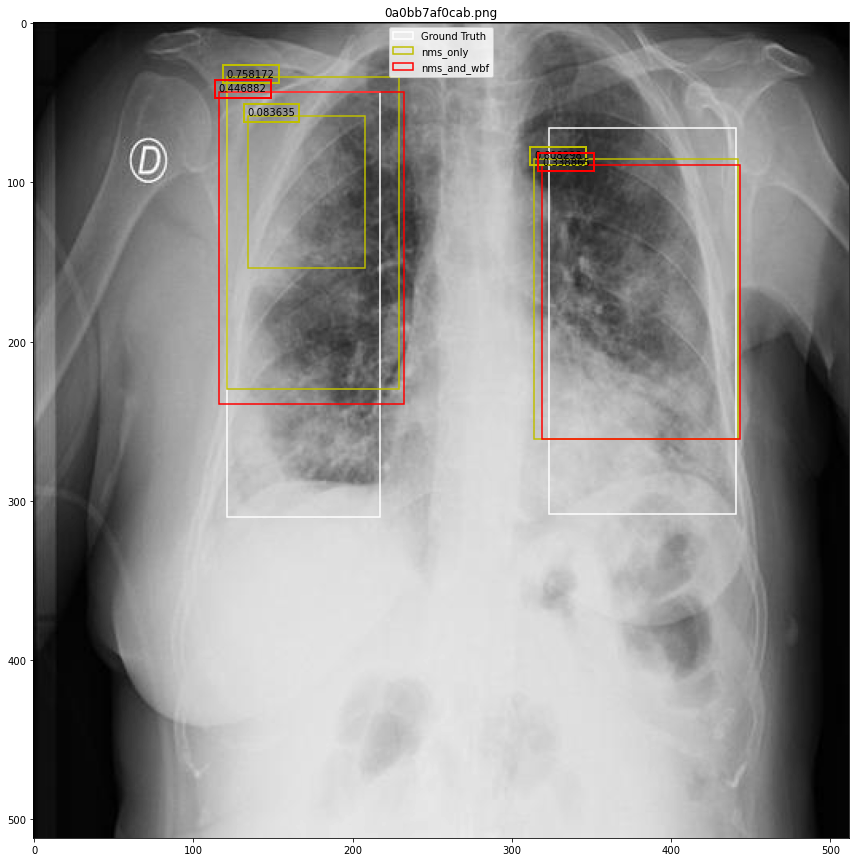

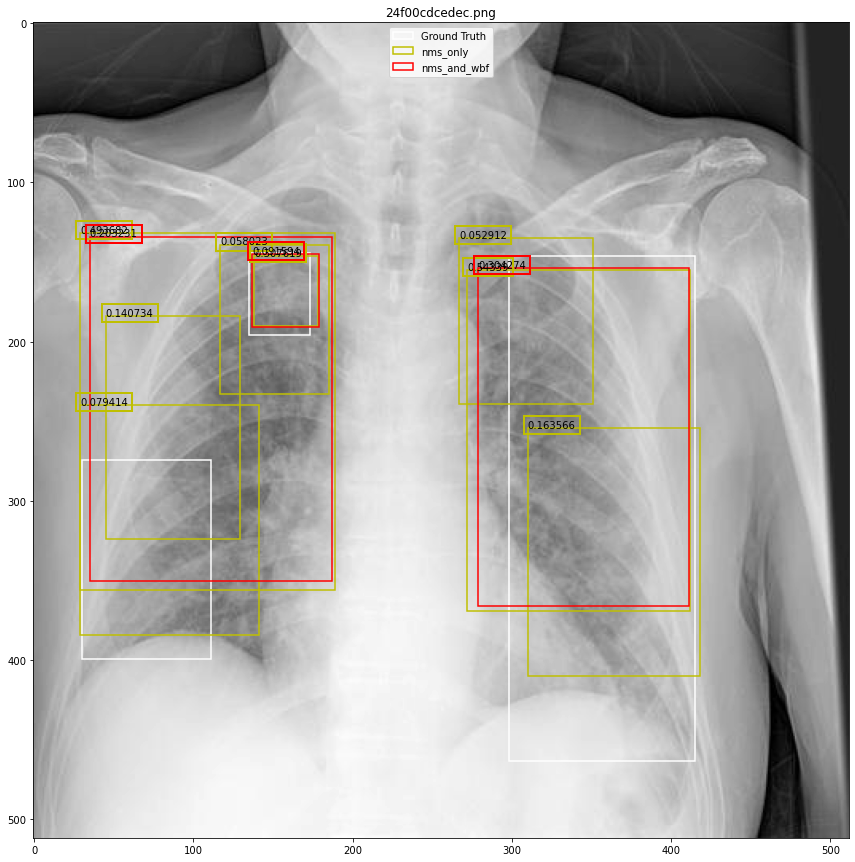

Missing label file for image 302436633ec0.png for run nms_and_wbf


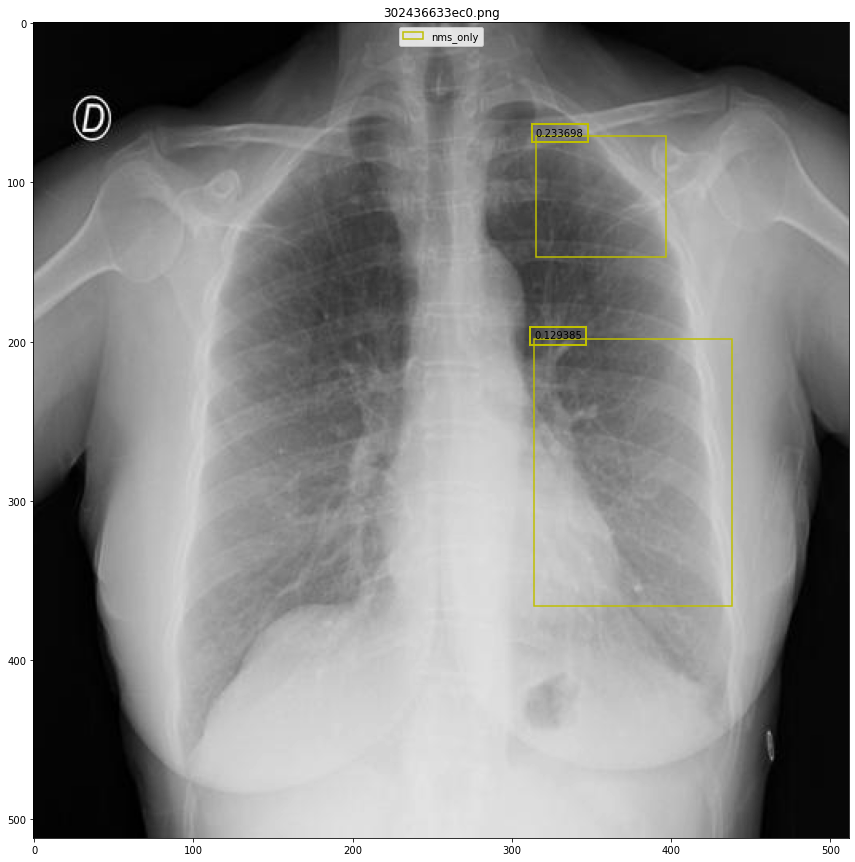

Missing label file for image 4145f29b1520.png for run nms_and_wbf


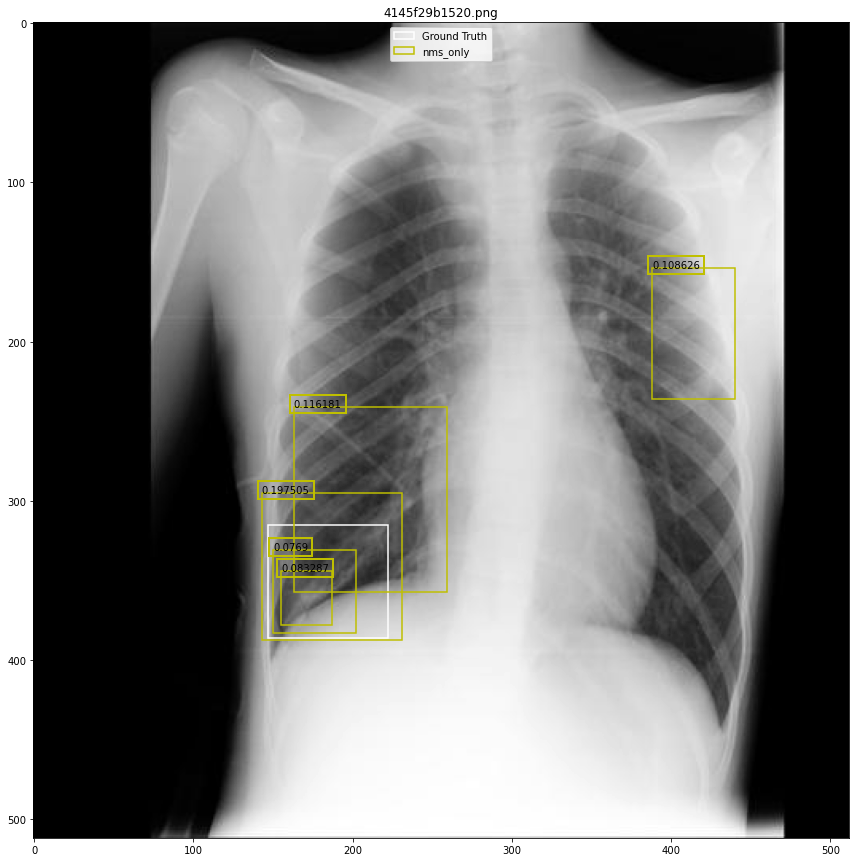

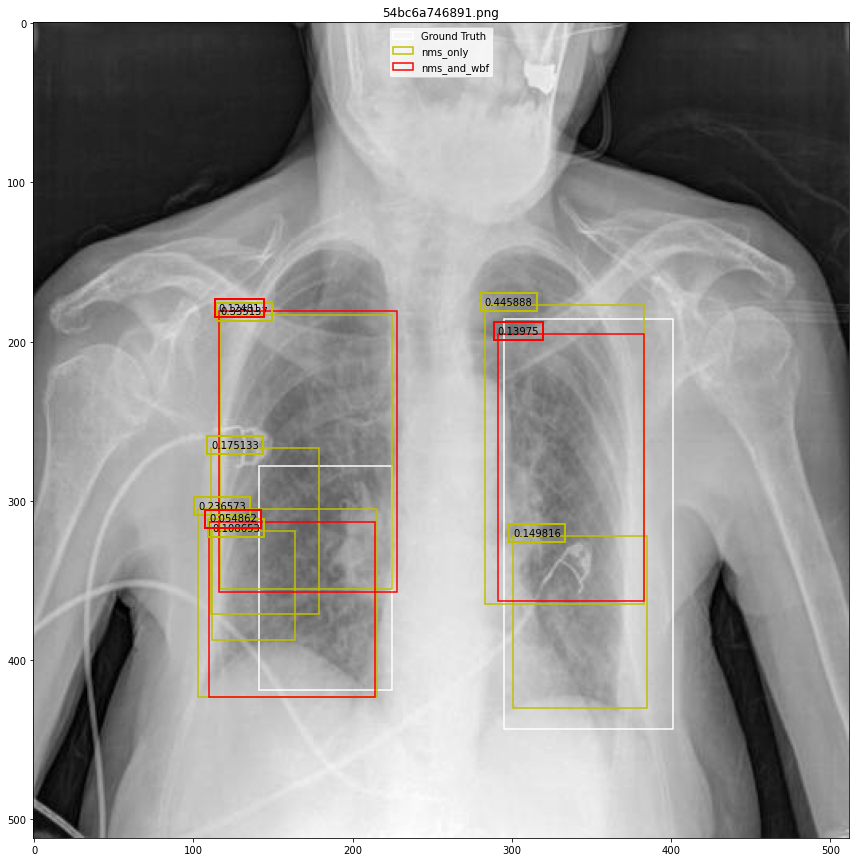

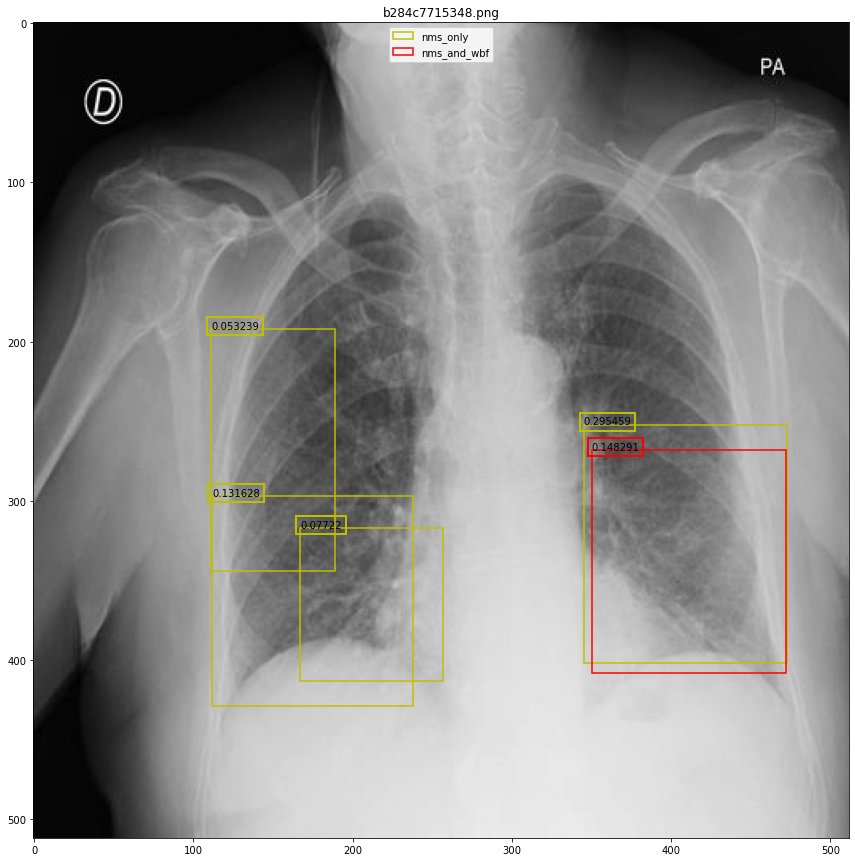

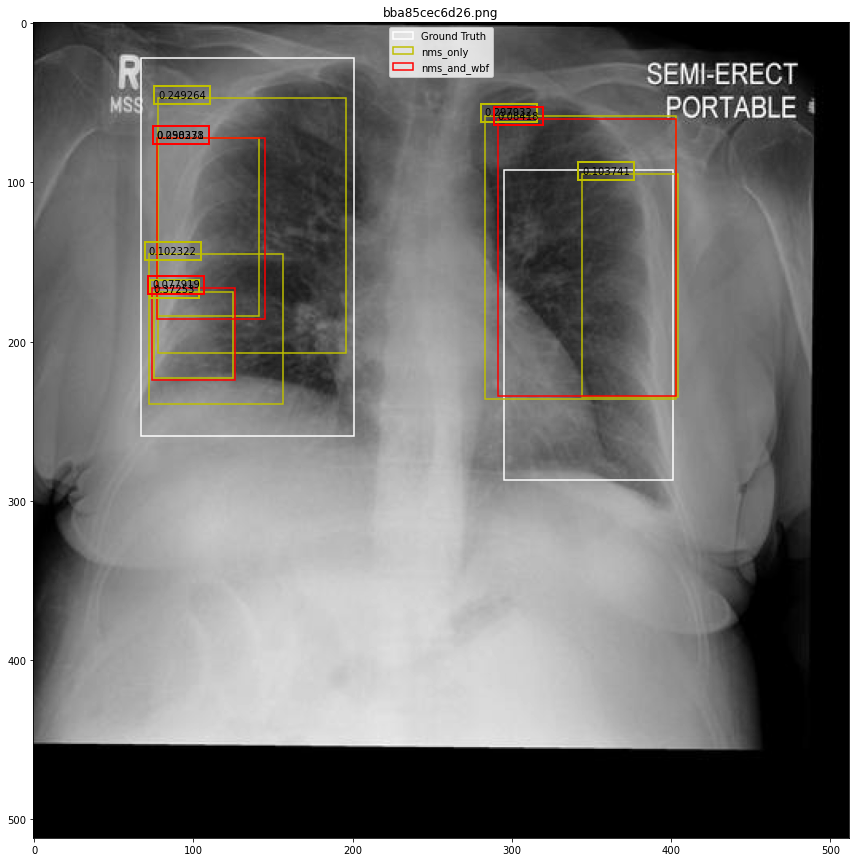

No handles with labels found to put in legend.


Missing label file for image ed3682285d63.png for run nms_only
Missing label file for image ed3682285d63.png for run nms_and_wbf


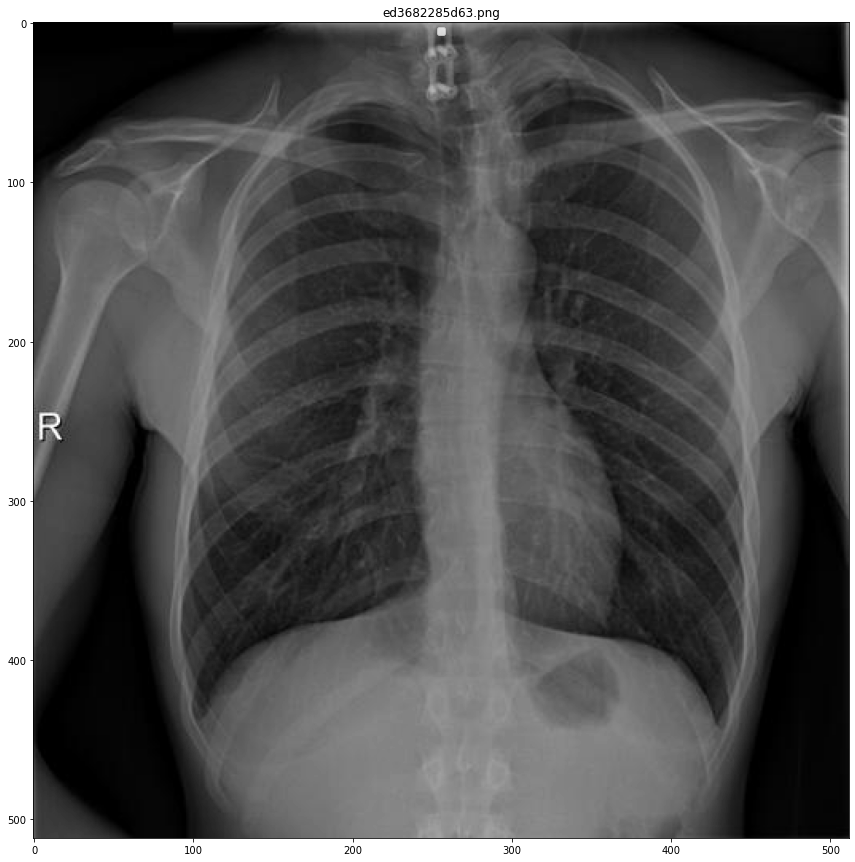

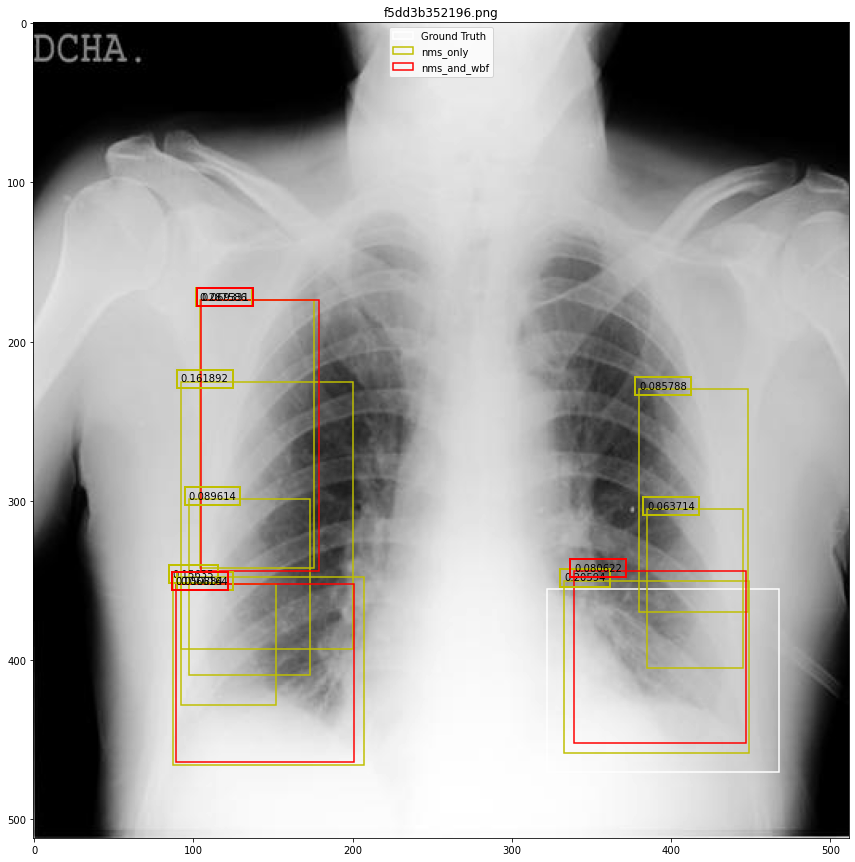

KeyError: 10

In [13]:
%%time
MAX_ROWS=25
# MAX_ROWS=len(df)

# clear dest dir first
if os.path.exists(OUTPUT_IMAGES_DIR):
    for file in os.scandir(OUTPUT_IMAGES_DIR):
        if os.path.isfile(file):
            os.remove(file.path)

#now lets generate images for all the rows we predicted for later display
#lets see a single image
uteda.generate_images(df, MAX_ROWS,  IMAGES_PATH,OUTPUT_IMAGES_DIR, run_names=RUNS, show_image=True, img_suffix=img_suffix)

In [ ]:
%%time
MAX_ROWS=25
# MAX_ROWS=len(df)

# clear dest dir first
if os.path.exists(OUTPUT_IMAGES_DIR):
    for file in os.scandir(OUTPUT_IMAGES_DIR):
        if os.path.isfile(file):
            os.remove(file.path)

#now lets generate images for all the rows we predicted for later display
#lets see a single image
uteda.generate_images(df, MAX_ROWS,  IMAGES_PATH,OUTPUT_IMAGES_DIR, run_names=RUNS, show_image=True, img_suffix=img_suffix)

# lets do a bunch

In [ ]:
RUNS=['wbf']

In [ ]:
%%time
MAX_ROWS=25
# MAX_ROWS=len(df)

# clear dest dir first
if os.path.exists(OUTPUT_IMAGES_DIR):
    for file in os.scandir(OUTPUT_IMAGES_DIR):
        if os.path.isfile(file):
            os.remove(file.path)

#now lets generate images for all the rows we predicted for later display
#lets see a single image
uteda.generate_images(df, MAX_ROWS,  IMAGES_PATH,OUTPUT_IMAGES_DIR, run_names=RUNS, show_image=True, img_suffix=img_suffix)

In [ ]:
%%time
MAX_ROWS=25
# MAX_ROWS=len(df)

# clear dest dir first
if os.path.exists(OUTPUT_IMAGES_DIR):
    for file in os.scandir(OUTPUT_IMAGES_DIR):
        if os.path.isfile(file):
            os.remove(file.path)

#now lets generate images for all the rows we predicted for later display
#lets see a single image
uteda.generate_images(df, MAX_ROWS,  IMAGES_PATH,OUTPUT_IMAGES_DIR, run_names=RUNS, show_image=True, img_suffix=img_suffix)

In [ ]:
%%time
MAX_ROWS=25
# MAX_ROWS=len(df)

# clear dest dir first
if os.path.exists(OUTPUT_IMAGES_DIR):
    for file in os.scandir(OUTPUT_IMAGES_DIR):
        if os.path.isfile(file):
            os.remove(file.path)

#now lets generate images for all the rows we predicted for later display
#lets see a single image
uteda.generate_images(df, MAX_ROWS,  IMAGES_PATH,OUTPUT_IMAGES_DIR, run_names=RUNS, show_image=True, img_suffix=img_suffix)

In [ ]:
%%time
MAX_ROWS=25
MAX_ROWS=len(df)

# clear dest dir first
if os.path.exists(OUTPUT_IMAGES_DIR):
    for file in os.scandir(OUTPUT_IMAGES_DIR):
        if os.path.isfile(file):
            os.remove(file.path)

#now lets generate images for all the rows we predicted for later display
#lets see a single image
uteda.generate_images(df, MAX_ROWS,  IMAGES_PATH,OUTPUT_IMAGES_DIR, run_names=RUNS, show_image=True, img_suffix=img_suffix)